In [273]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import io
import re
from scipy.io.wavfile import read
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
from datetime import datetime, timezone
import datetime
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from pathlib import Path
from sklearn.cluster import KMeans
import copy
from scipy.stats import mode


In [274]:
def load_waveform(filepath):
    with open(filepath) as dataFile:
        data = dataFile.read()
        # Check for missing commas and insert them
        pattern = r'(\{[^{}]*"[^"]*"[^{}]*\})(?=[^{}]*\{)'
        data = re.sub(pattern, r'\1,', data)

        obj = data[data.find('{') : data.rfind('}')+1]
        jsonObj = json.loads(obj)
        
        if jsonObj['data']:
            waveform_data = pd.DataFrame(jsonObj['data'], columns=["peak_amplitude","integral","phase_angle","cycle_number","rise_time","pulse_width"])    
            return waveform_data
    return None


In [275]:
dirpath = "test"

In [276]:
# load data into dataframes
dataframes = []
for filename in os.listdir(dirpath):
    if filename.endswith(".js"):
        filepath = os.path.join(dirpath, filename)
        waveform = load_waveform(filepath)
        if not waveform.empty:
            waveform['filename'] = filename # Add filename as a column
            dataframes.append(waveform)

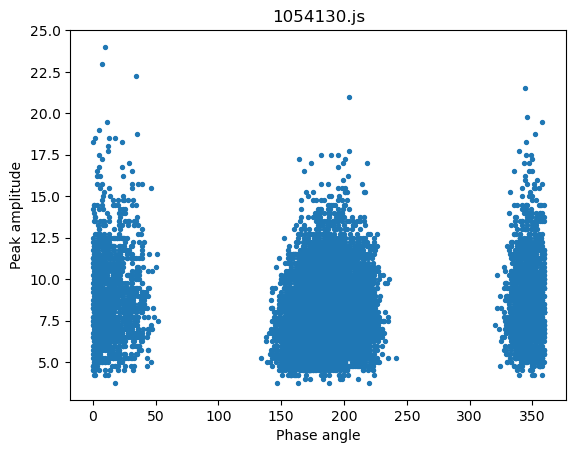

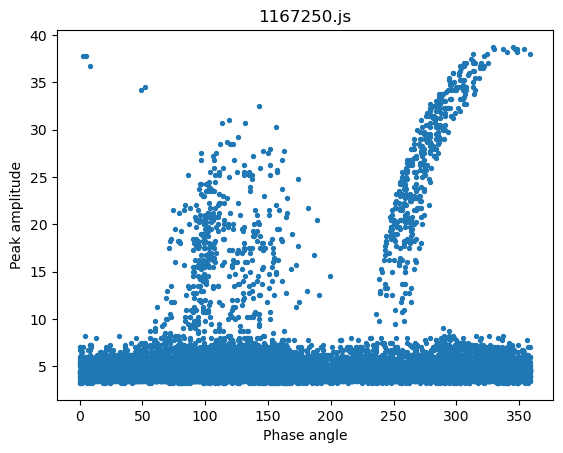

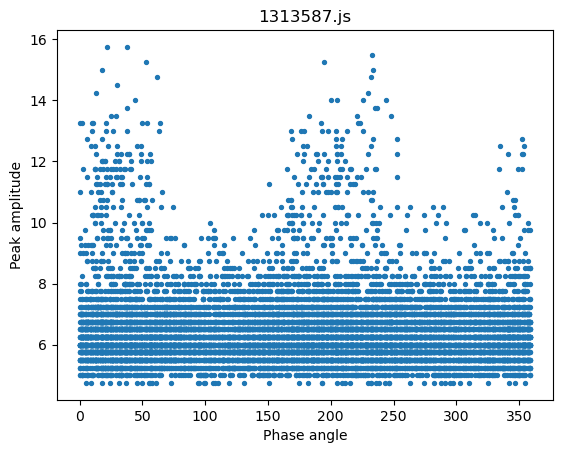

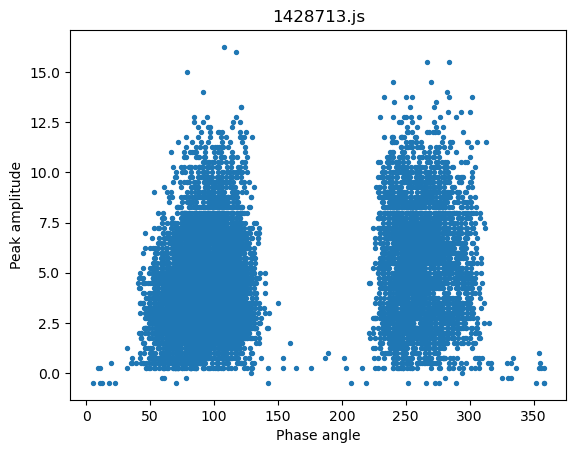

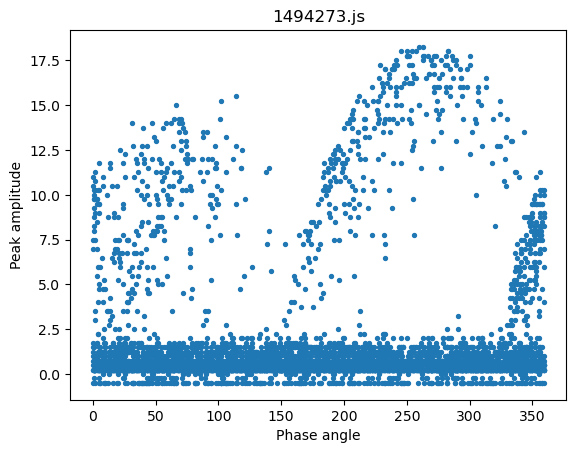

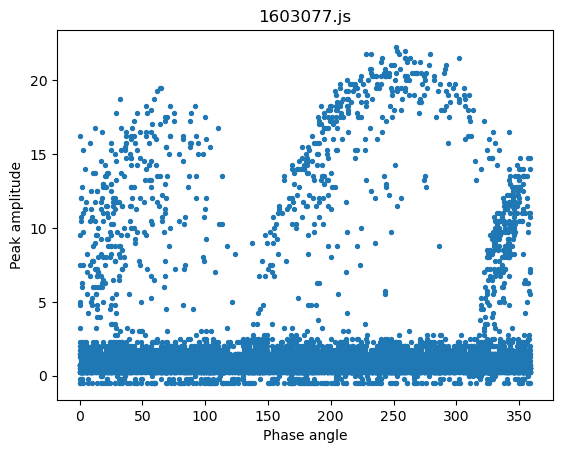

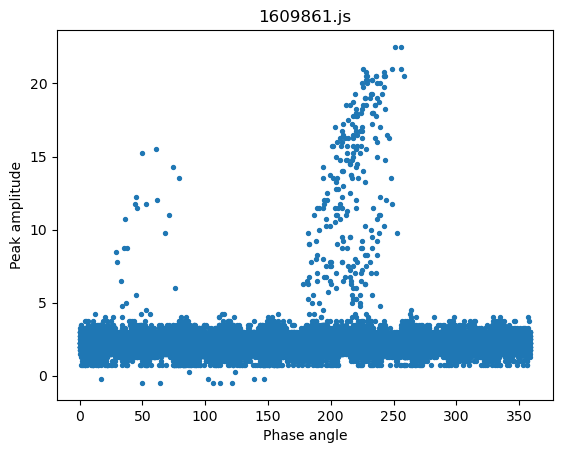

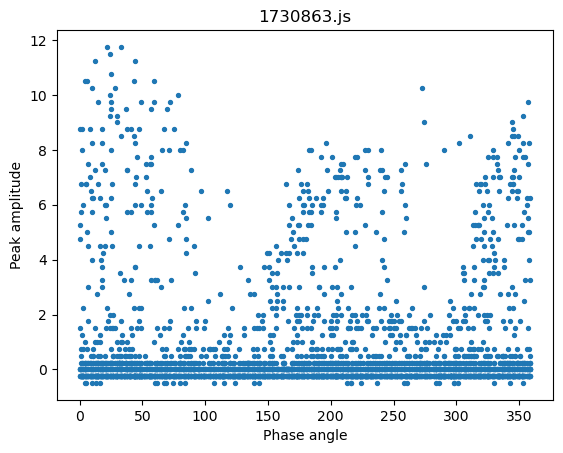

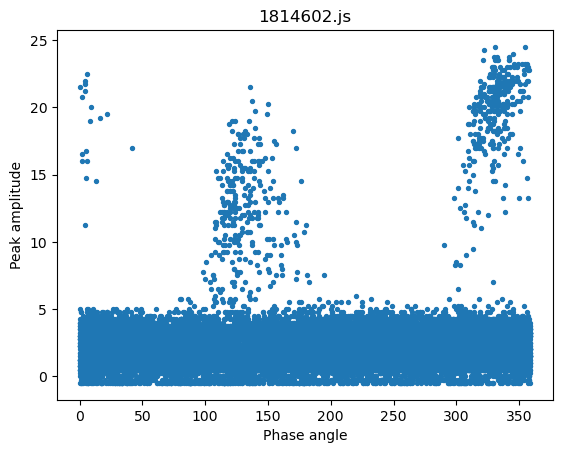

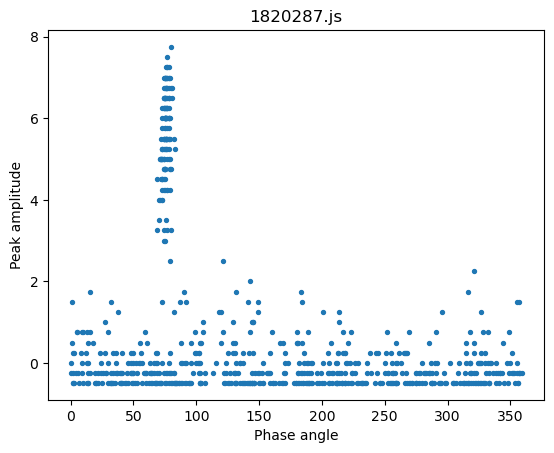

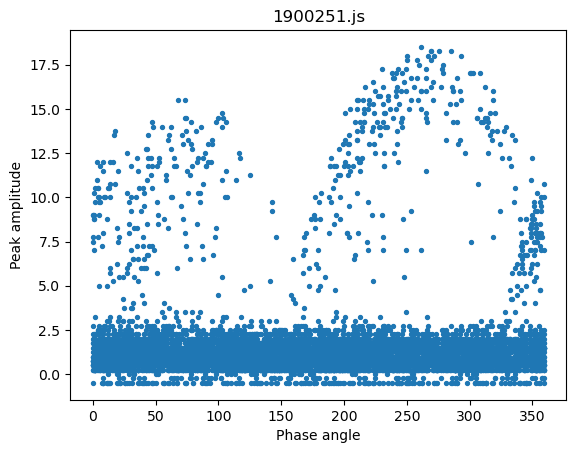

In [277]:
for dataframe in dataframes: # show data into plots
    plt.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    plt.title(dataframe['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()

In [278]:
print(dataframes[1])


       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                6.00      3475          117         37730          0   
1                7.75    -12632          121         37730          0   
2                6.25    -14036          121         37730          0   
3                5.50     -4588          123         37730          0   
4                6.25     -8501          125         37730          0   
...               ...       ...          ...           ...        ...   
13746            3.50     -1674          278         38228          0   
13747            4.50      1473          279         38228          0   
13748            3.50      4140          280         38228          0   
13749            4.25     -6666          281         38228          0   
13750            4.00      3144          281         38228          0   

       pulse_width    filename  
0                0  1167250.js  
1                0  1167250.js  
2                0  1167

In [279]:
unique_files = set()

for df in dataframes:
    unique_files = unique_files.union(set(df['filename'].unique()))

print(unique_files)

{'1167250.js', '1900251.js', '1603077.js', '1820287.js', '1054130.js', '1494273.js', '1609861.js', '1730863.js', '1428713.js', '1313587.js', '1814602.js'}


In [280]:
# for df in dataframes:
#     # split phase_angle column into 36 buckets
#     df['bucket'] = pd.cut(df['phase_angle'], bins=range(0, 361, 10), labels=False)

In [281]:
# print(dataframes[1]['bucket'])

In [282]:
print(dataframes[1])

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                6.00      3475          117         37730          0   
1                7.75    -12632          121         37730          0   
2                6.25    -14036          121         37730          0   
3                5.50     -4588          123         37730          0   
4                6.25     -8501          125         37730          0   
...               ...       ...          ...           ...        ...   
13746            3.50     -1674          278         38228          0   
13747            4.50      1473          279         38228          0   
13748            3.50      4140          280         38228          0   
13749            4.25     -6666          281         38228          0   
13750            4.00      3144          281         38228          0   

       pulse_width    filename  
0                0  1167250.js  
1                0  1167250.js  
2                0  1167

In [283]:
# for dataframe in dataframes: #show new graphs with bucket lines
#     fig, ax = plt.subplots()
#     ax.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8, cmap=cmx.plasma)
#     ax.set_title(dataframe['filename'].iloc[0])
#     ax.set_xlabel('Phase angle')
#     ax.set_ylabel('Peak amplitude')
#     # Define the bucket boundaries
#     bucket_boundaries = np.linspace(0, 360, 37)
#     for i in range(1, len(bucket_boundaries)-1):
#         ax.axvline(bucket_boundaries[i], color='red', linestyle='--')
#     plt.show()


In [284]:
def determine_baseline(bucket_data, kmeans, predicted_clusters, threshold=5):
    centroids = kmeans.cluster_centers_
    centroid_distance = abs(centroids[1] - centroids[0])

    if centroid_distance > threshold:
        # Clusters far apart - Outcome 1
        lower_centroid_index = np.argmin(centroids)
        lower_cluster = bucket_data[predicted_clusters == lower_centroid_index]
        return max(lower_cluster['peak_amplitude'])
    else:
        # Clusters close together - Outcome 2
        higher_centroid_index = np.argmax(centroids)
        return centroids[higher_centroid_index][0]

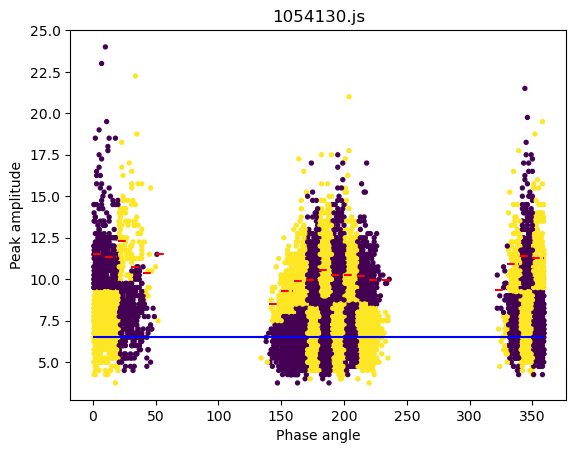

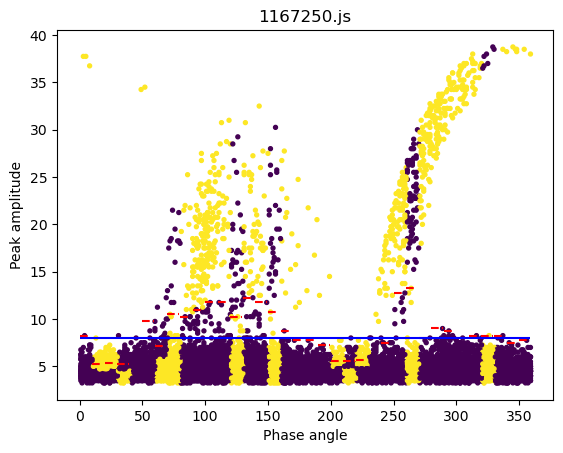

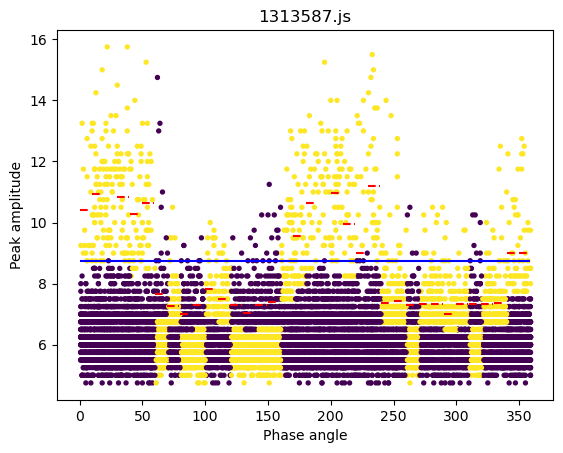

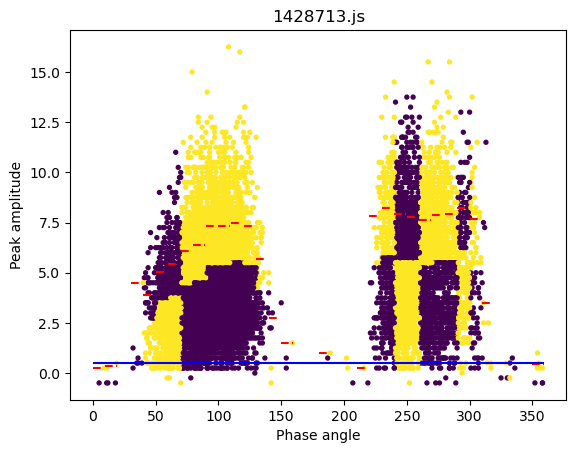

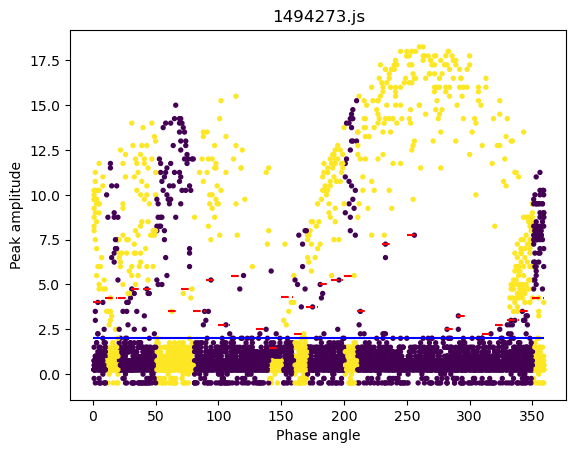

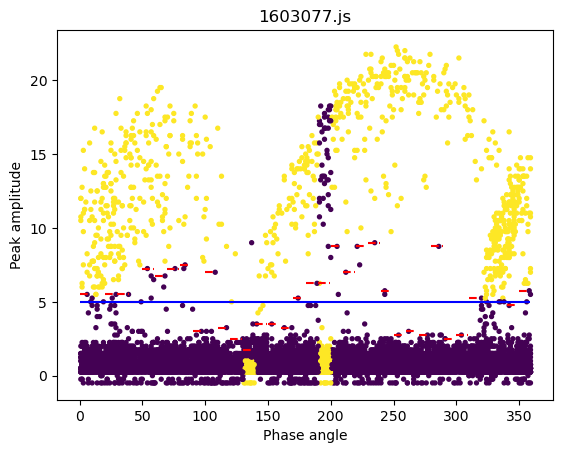

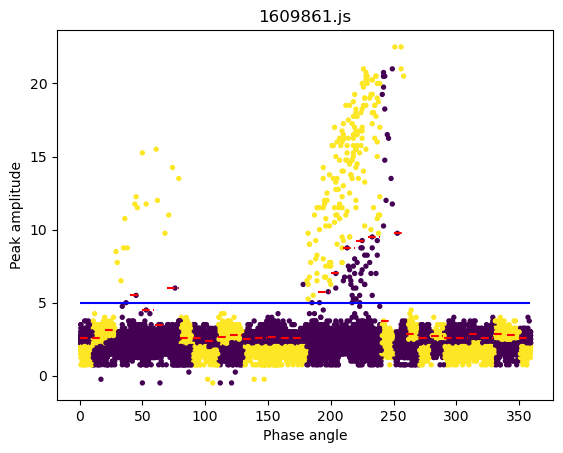

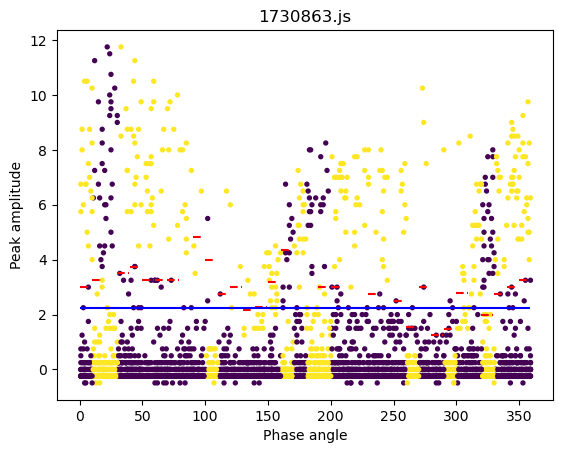

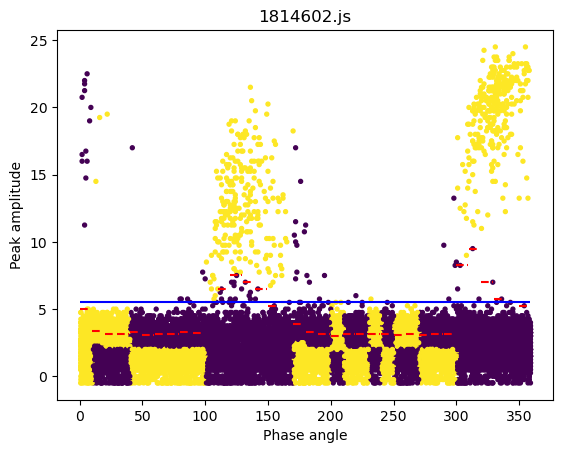

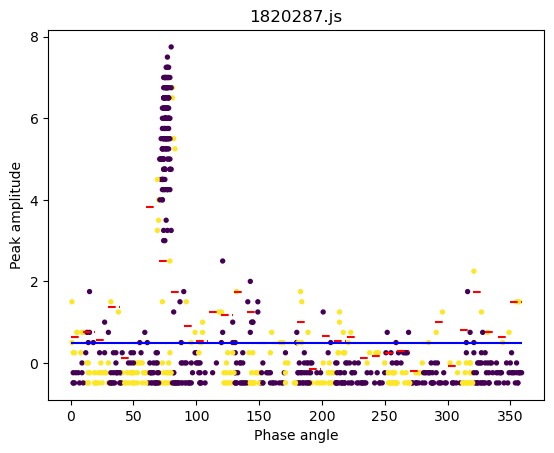

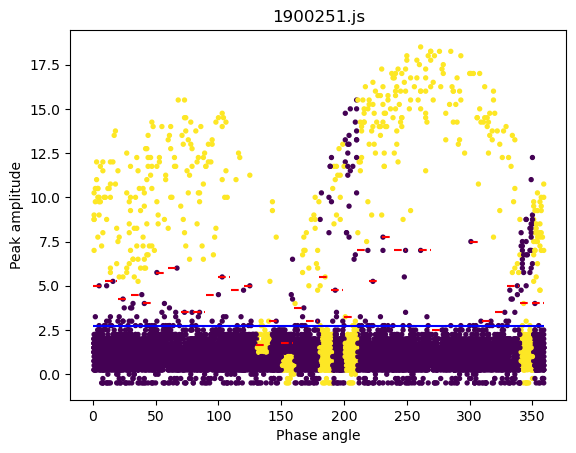

In [285]:
warnings.filterwarnings('ignore')
for df in dataframes:
    # Bucket phase angles
    df['bucket'] = pd.cut(df['phase_angle'], bins=range(0, 361, 10), labels=False)

    # Perform k-means clustering on each bucket and determine baselines
    kmeans_results = []
    bucket_baselines = []
    for i in range(36):
        bucket_data = df[df['bucket'] == i]
        if not bucket_data.empty and len(bucket_data) > 1:
            kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
            kmeans.fit(bucket_data['peak_amplitude'].values.reshape(-1, 1))
            kmeans_results.append((i, kmeans))

            # Predict the clusters for bucket_data
            predicted_clusters = kmeans.predict(bucket_data['peak_amplitude'].values.reshape(-1, 1))

            # Pass the predicted clusters to the determine_baseline function
            baseline = determine_baseline(bucket_data, kmeans, predicted_clusters)
            bucket_baselines.append((i, baseline))
        else:
            kmeans_results.append((i, None))
            bucket_baselines.append((i, None))

    # Assign cluster labels to each data point
    df['cluster'] = np.nan
    for i, kmeans in kmeans_results:
        if kmeans is not None:
            mask = df['bucket'] == i
            df.loc[mask, 'cluster'] = kmeans.predict(df.loc[mask, 'peak_amplitude'].values.reshape(-1, 1))
            
    baselines = [baseline for _, baseline in bucket_baselines if baseline is not None]
    basemode = mode(baselines).mode[0]

    # Remove points below the baseline mode (inserted)
    df.loc[:, 'filtered'] = df['peak_amplitude'] >= basemode
    
    # Scatter plot with bucketed phase angles and clustered data points
    plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
    plt.title(df['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')

    # Plot baselines
    for i, baseline in bucket_baselines:
        if baseline is not None:
            plt.hlines(baseline, i * 10, (i + 1) * 10 - 1, colors='r', linestyles='dashed')
    plt.hlines(basemode, 0, 359, colors='b', linestyles='solid')
    plt.show()

    # # Save the plot
    # output_filename = os.path.join(output_folder, f"{os.path.splitext(df['filename'].iloc[0])[0]}_PRPD_plot.png")
    # plt.savefig(output_filename, dpi=300)
    # plt.close()


In [286]:
print(dataframes[1])

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
0                6.00      3475          117         37730          0   
1                7.75    -12632          121         37730          0   
2                6.25    -14036          121         37730          0   
3                5.50     -4588          123         37730          0   
4                6.25     -8501          125         37730          0   
...               ...       ...          ...           ...        ...   
13746            3.50     -1674          278         38228          0   
13747            4.50      1473          279         38228          0   
13748            3.50      4140          280         38228          0   
13749            4.25     -6666          281         38228          0   
13750            4.00      3144          281         38228          0   

       pulse_width    filename  bucket  cluster  filtered  
0                0  1167250.js    11.0      0.0     False  
1  

In [287]:
filtered_dataframes = [df[df['filtered'] == True] for df in dataframes]

In [288]:
print(filtered_dataframes[1])

       peak_amplitude  integral  phase_angle  cycle_number  rise_time  \
5                8.75      4440          133         37730          0   
59              34.50     26597          302         37730          3   
159             10.00      2518           69         37731          3   
321             23.25      6459          257         37731          3   
325             10.50      1993          120         37732          0   
...               ...       ...          ...           ...        ...   
13683           20.00      8397          122         38227          3   
13685           18.75      5224          264         38227          3   
13690           14.00      2719           98         38228          0   
13691            8.00    -11503          133         38228          0   
13732           22.75      8688          267         38228          2   

       pulse_width    filename  bucket  cluster  filtered  
5                1  1167250.js    13.0      0.0      True  
59 

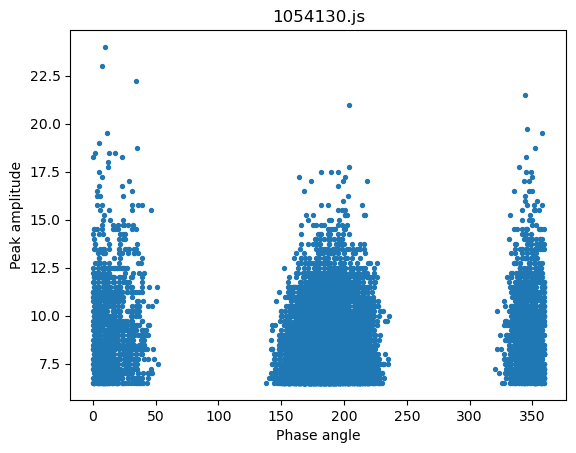

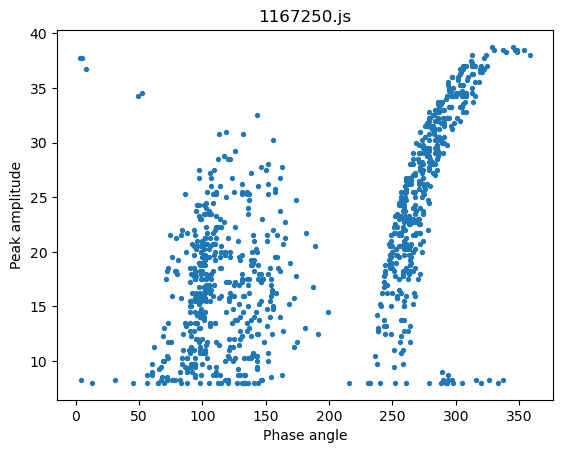

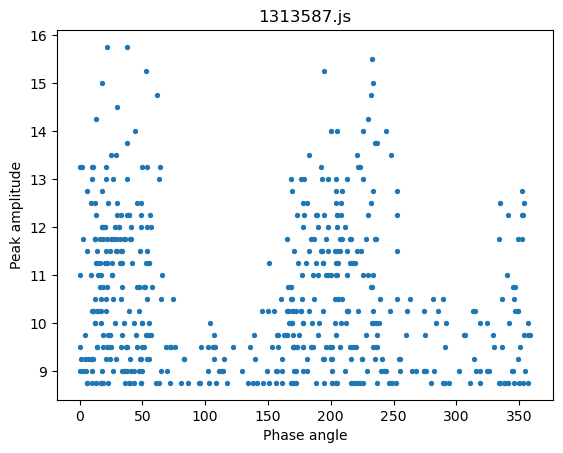

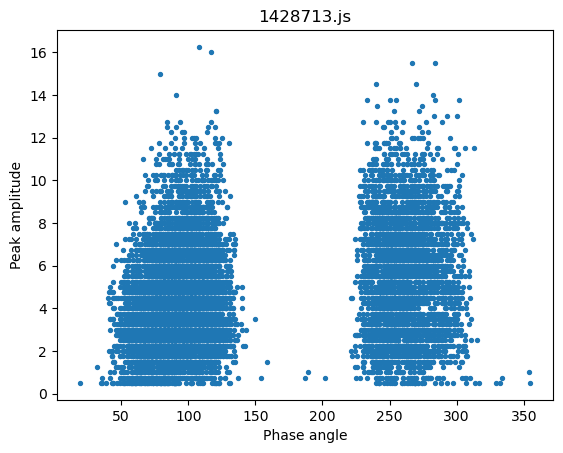

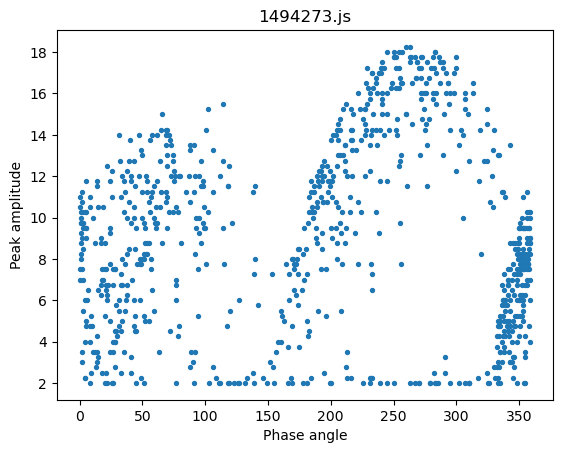

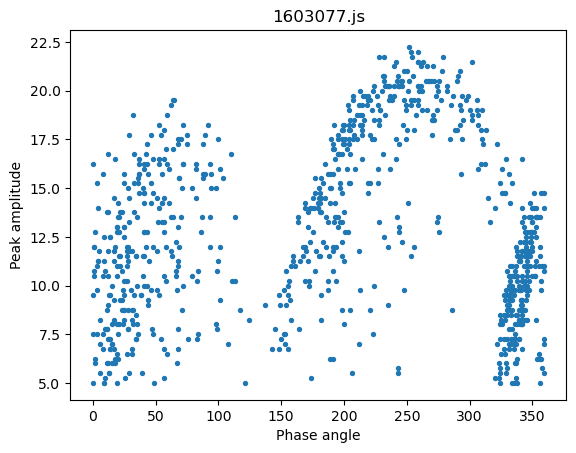

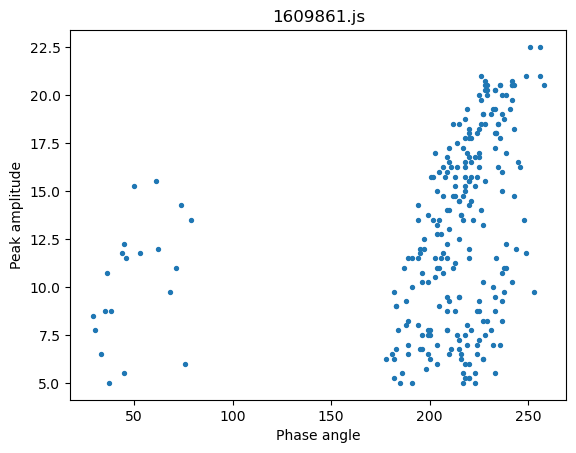

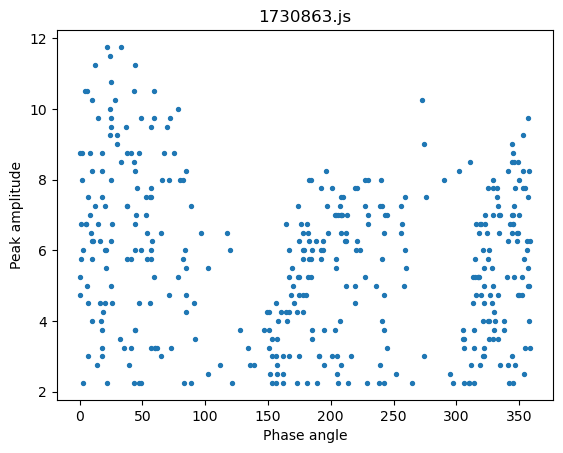

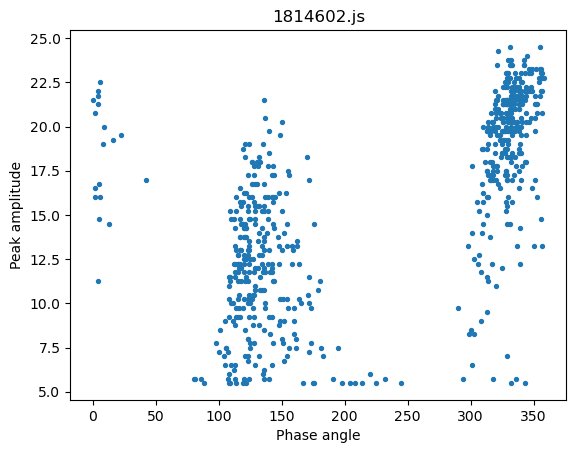

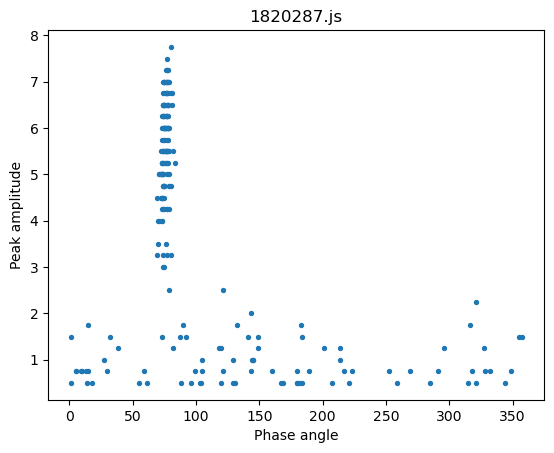

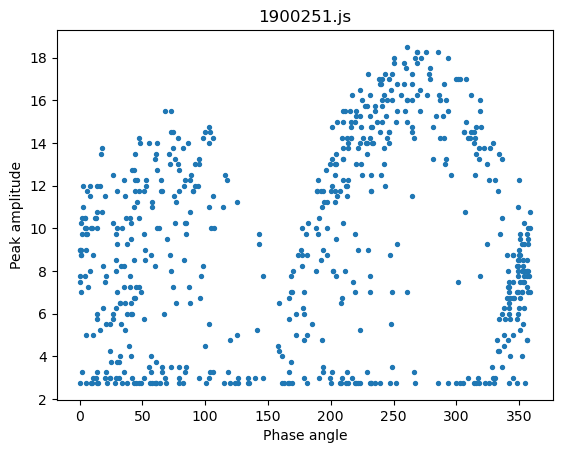

In [289]:
for dataframe in filtered_dataframes: #show new graphs with threshold removed
    fig, ax = plt.subplots()
    ax.scatter(dataframe['phase_angle'], dataframe['peak_amplitude'], s=8)
    ax.set_title(dataframe['filename'].iloc[0])
    ax.set_xlabel('Phase angle')
    ax.set_ylabel('Peak amplitude')


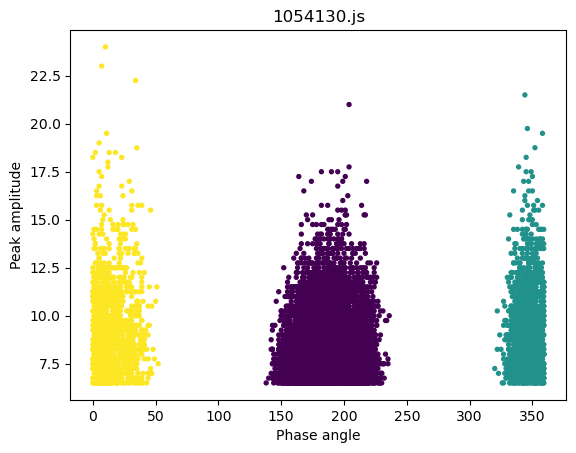

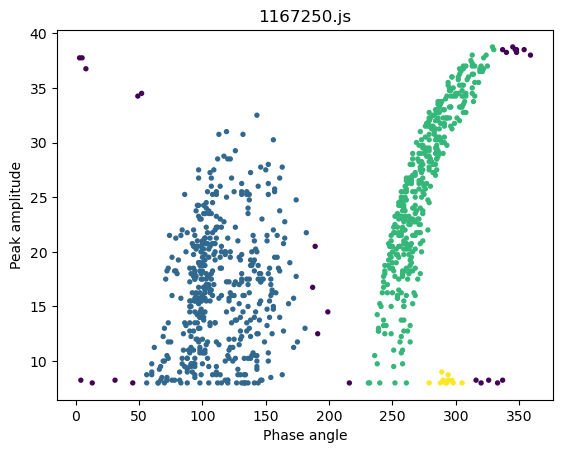

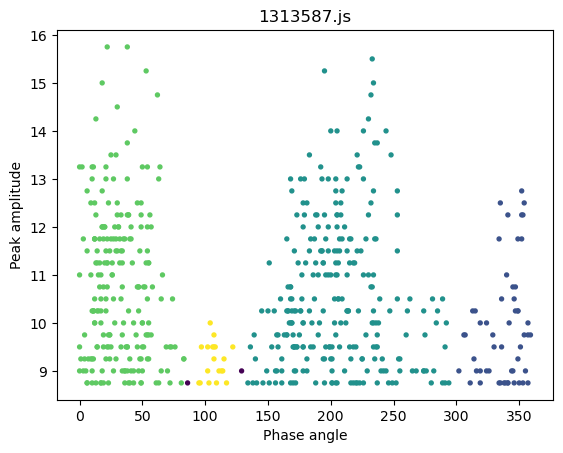

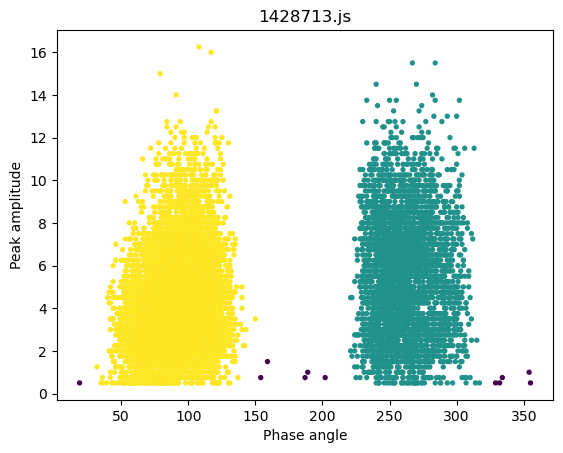

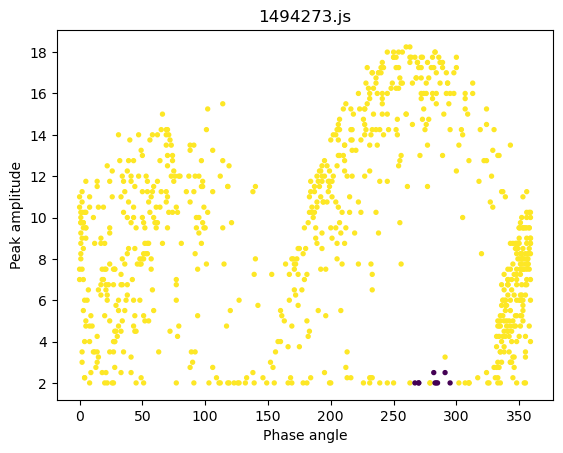

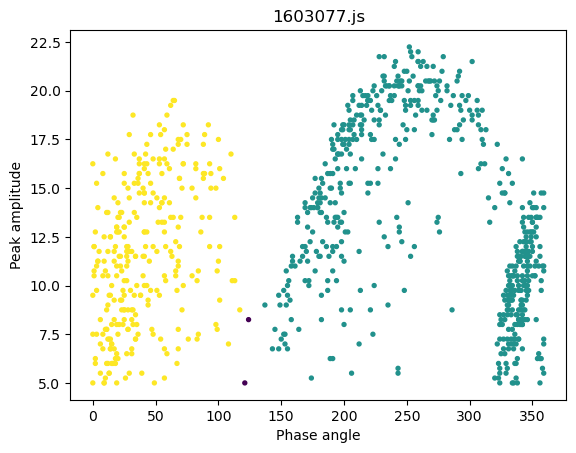

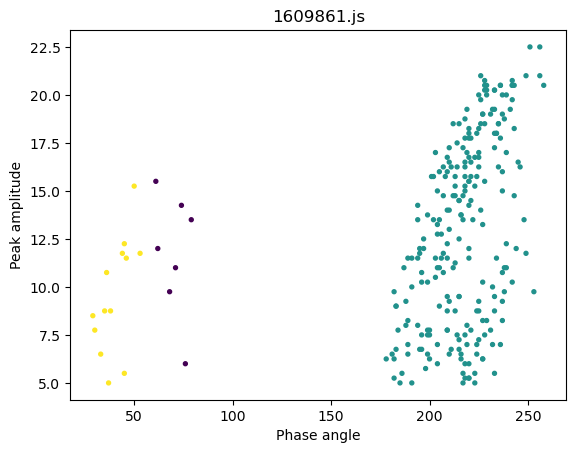

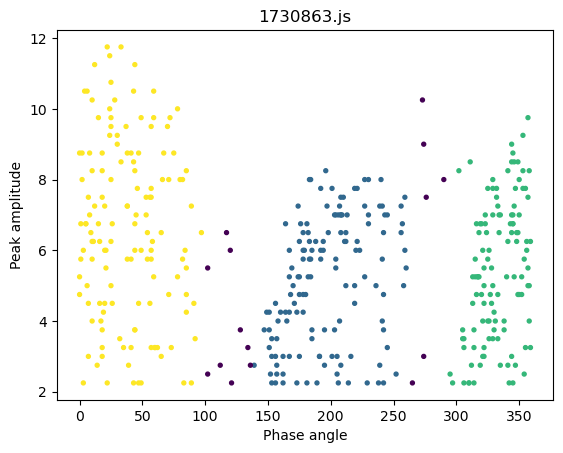

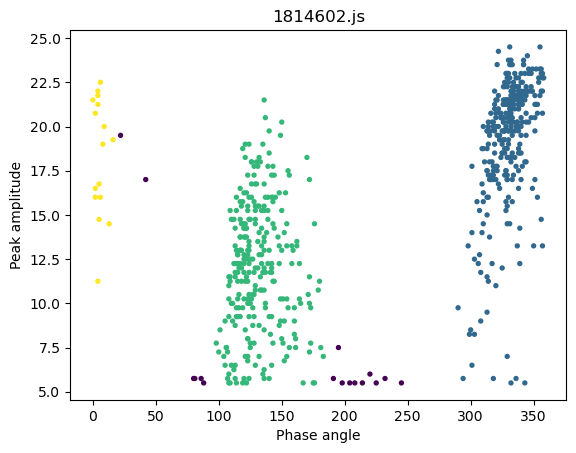

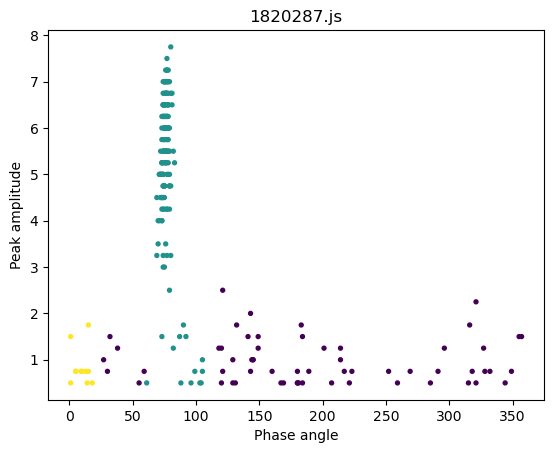

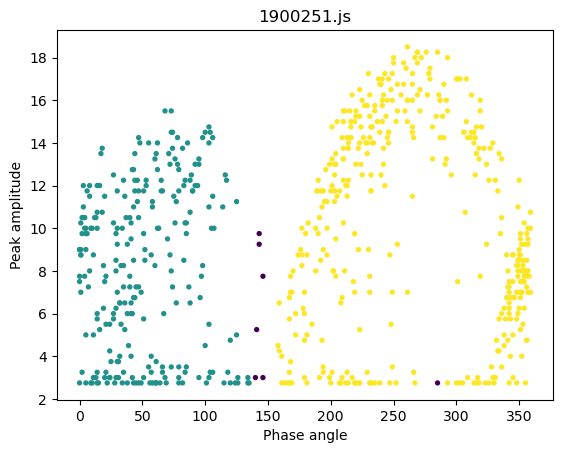

In [290]:
# Initialize lists for the cluster features
for df in filtered_dataframes:
    # Extract the relevant columns
    X = df[['phase_angle', 'peak_amplitude']].values
    
    # Apply DBSCAN to the data
    dbscan = DBSCAN(eps=10, min_samples=10)
    dbscan.fit(X)
    labels = dbscan.labels_
    
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Add the cluster labels to the dataframe copy
    df_copy['cluster'] = labels
    
    # Access cluster information
    clusters = set(labels)
    for cluster in clusters:
        if cluster != -1:
            # Get the points belonging to the cluster
            cluster_points = X[labels == cluster]
            
            # Calculate cluster features
            cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
            cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
            cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
            cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
            
            # Add new columns for cluster features to the dataframe copy
            df_copy.loc[labels == cluster, 'cluster_length'] = cluster_length
            df_copy.loc[labels == cluster, 'cluster_height'] = cluster_height
            df_copy.loc[labels == cluster, 'cluster_gradient_tr'] = cluster_gradient_tr
            df_copy.loc[labels == cluster, 'cluster_gradient_tl'] = cluster_gradient_tl
    
    # Assign the cluster labels and features to the original dataframe
    df.loc[:, 'cluster'] = df_copy['cluster']
    df.loc[:, 'cluster_length'] = df_copy['cluster_length']
    df.loc[:, 'cluster_height'] = df_copy['cluster_height']
    df.loc[:, 'cluster_gradient_tr'] = df_copy['cluster_gradient_tr']
    df.loc[:, 'cluster_gradient_tl'] = df_copy['cluster_gradient_tl']
    
    # Plot the clustered data
    plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
    plt.title(df['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()


Cluster 0: Length=98.0, Height=14.5, GradientTR=0.14795918367346939, GradientTL=-0.14795918367346939
Cluster 1: Length=39.0, Height=15.0, GradientTR=0.38461538461538464, GradientTL=-0.38461538461538464
Cluster 2: Length=52.0, Height=17.5, GradientTR=0.33653846153846156, GradientTL=-0.33653846153846156


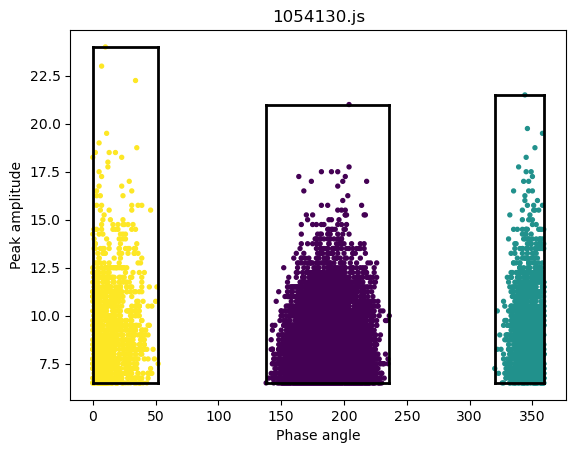

Cluster 0: Length=126.0, Height=24.5, GradientTR=0.19444444444444445, GradientTL=-0.19444444444444445
Cluster 1: Length=99.0, Height=30.75, GradientTR=0.3106060606060606, GradientTL=-0.3106060606060606
Cluster 2: Length=26.0, Height=1.0, GradientTR=0.038461538461538464, GradientTL=-0.038461538461538464


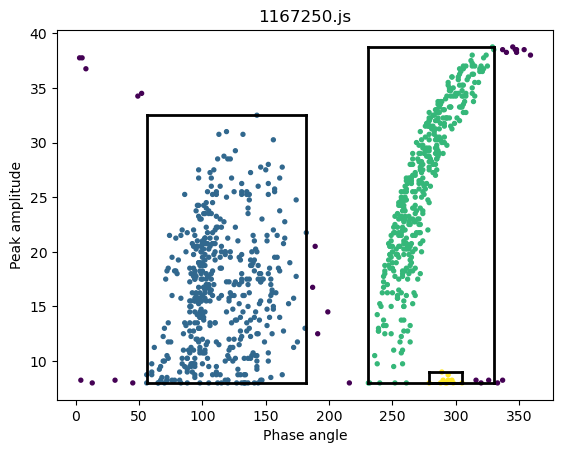

Cluster 0: Length=57.0, Height=4.0, GradientTR=0.07017543859649122, GradientTL=-0.07017543859649122
Cluster 1: Length=160.0, Height=6.75, GradientTR=0.0421875, GradientTL=-0.0421875
Cluster 2: Length=83.0, Height=7.0, GradientTR=0.08433734939759036, GradientTL=-0.08433734939759036
Cluster 3: Length=27.0, Height=1.25, GradientTR=0.046296296296296294, GradientTL=-0.046296296296296294


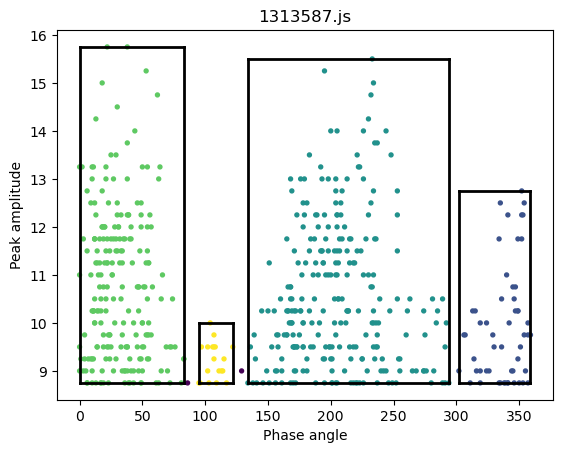

Cluster 0: Length=96.0, Height=15.0, GradientTR=0.15625, GradientTL=-0.15625
Cluster 1: Length=118.0, Height=15.75, GradientTR=0.13347457627118645, GradientTL=-0.13347457627118645


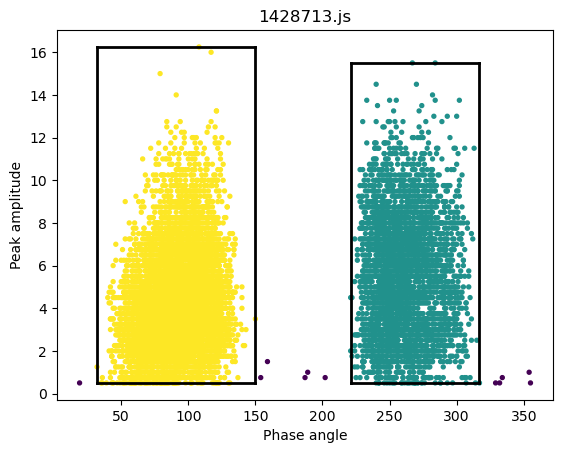

Cluster 0: Length=359.0, Height=16.25, GradientTR=0.04526462395543175, GradientTL=-0.04526462395543175


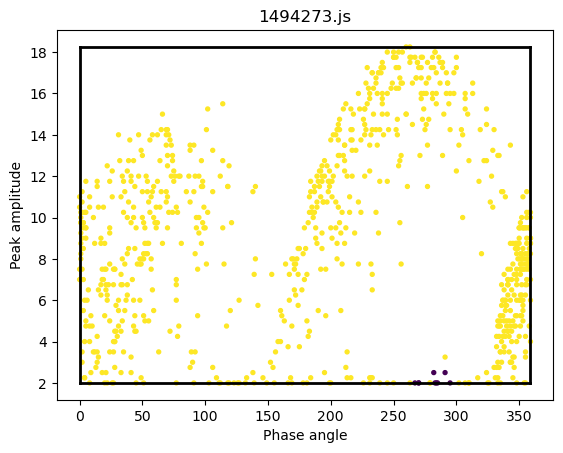

Cluster 0: Length=222.0, Height=17.25, GradientTR=0.0777027027027027, GradientTL=-0.0777027027027027
Cluster 1: Length=117.0, Height=14.5, GradientTR=0.12393162393162394, GradientTL=-0.12393162393162394


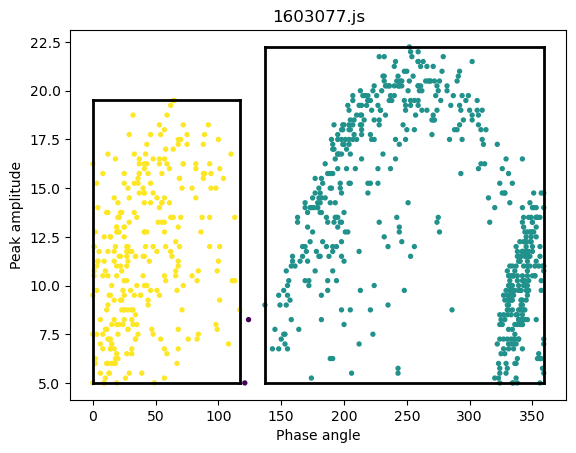

Cluster 0: Length=80.0, Height=17.5, GradientTR=0.21875, GradientTL=-0.21875
Cluster 1: Length=24.0, Height=10.25, GradientTR=0.4270833333333333, GradientTL=-0.4270833333333333


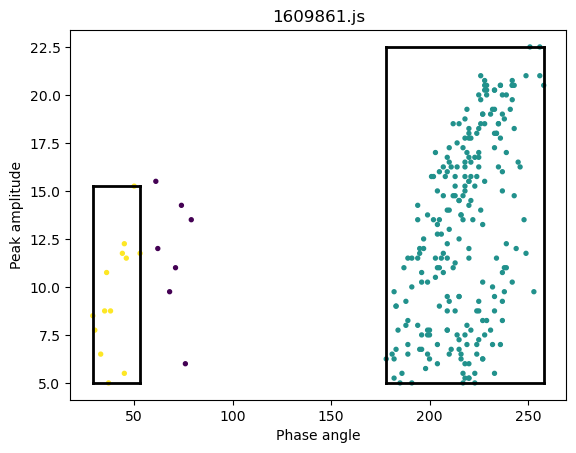

Cluster 0: Length=121.0, Height=6.0, GradientTR=0.049586776859504134, GradientTL=-0.049586776859504134
Cluster 1: Length=64.0, Height=7.5, GradientTR=0.1171875, GradientTL=-0.1171875
Cluster 2: Length=97.0, Height=9.5, GradientTR=0.0979381443298969, GradientTL=-0.0979381443298969


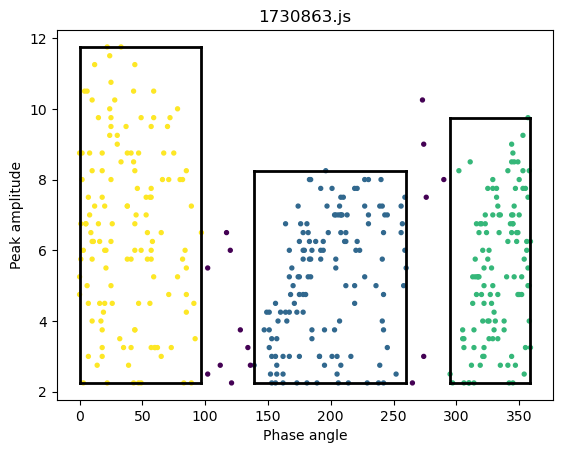

Cluster 0: Length=68.0, Height=19.0, GradientTR=0.27941176470588236, GradientTL=-0.27941176470588236
Cluster 1: Length=85.0, Height=16.0, GradientTR=0.18823529411764706, GradientTL=-0.18823529411764706
Cluster 2: Length=16.0, Height=11.25, GradientTR=0.703125, GradientTL=-0.703125


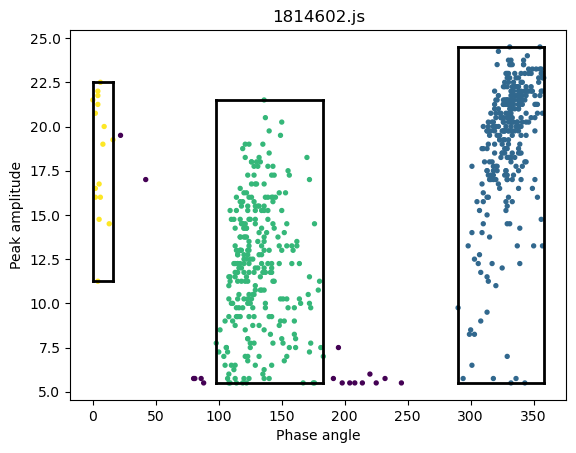

Cluster 0: Length=44.0, Height=7.25, GradientTR=0.16477272727272727, GradientTL=-0.16477272727272727
Cluster 1: Length=17.0, Height=1.25, GradientTR=0.07352941176470588, GradientTL=-0.07352941176470588


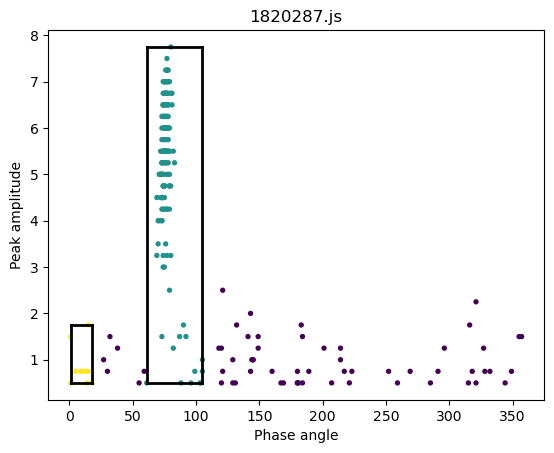

Cluster 0: Length=135.0, Height=12.75, GradientTR=0.09444444444444444, GradientTL=-0.09444444444444444
Cluster 1: Length=201.0, Height=15.75, GradientTR=0.07835820895522388, GradientTL=-0.07835820895522388


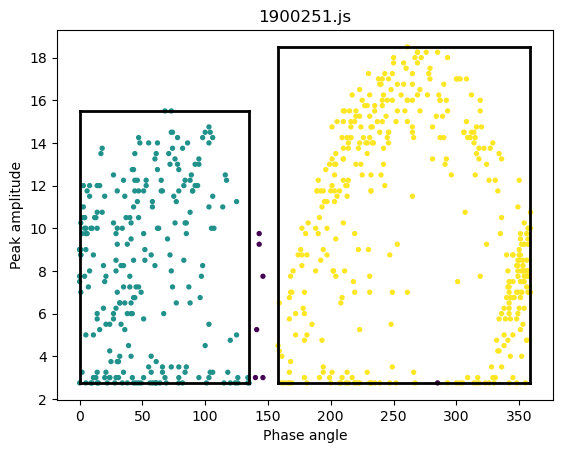

In [291]:
def plot_cluster_bounds(cluster_points):
    x_min, x_max = cluster_points[:, 0].min(), cluster_points[:, 0].max()
    y_min, y_max = cluster_points[:, 1].min(), cluster_points[:, 1].max()
    plt.plot([x_min, x_max], [y_min, y_min], 'k-', linewidth=2)
    plt.plot([x_max, x_max], [y_min, y_max], 'k-', linewidth=2)
    plt.plot([x_max, x_min], [y_max, y_max], 'k-', linewidth=2)
    plt.plot([x_min, x_min], [y_max, y_min], 'k-', linewidth=2)


for df in filtered_dataframes:
    # Extract the relevant columns
    X = df[['phase_angle', 'peak_amplitude']].values
    
    # Apply DBSCAN to the data
    dbscan = DBSCAN(eps=10, min_samples=10)
    dbscan.fit(X)
    labels = dbscan.labels_
    
    # Add the cluster labels to the dataframe
    df['cluster'] = labels
    
    # Create new columns for each cluster label
    dummies = pd.get_dummies(df['cluster'], prefix='cluster')
    df = pd.concat([df, dummies], axis=1)
    
    # Access cluster information
    clusters = set(labels)
    for cluster in clusters:
        if cluster != -1:
            # Get the points belonging to the cluster
            cluster_points = X[labels == cluster]
            
            # Calculate cluster features
            cluster_length = cluster_points[:, 0].max() - cluster_points[:, 0].min()
            cluster_height = cluster_points[:, 1].max() - cluster_points[:, 1].min()
            cluster_gradient_tr = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].max() - cluster_points[:, 0].min())
            cluster_gradient_tl = (cluster_points[:, 1].max() - cluster_points[:, 1].min()) / (cluster_points[:, 0].min() - cluster_points[:, 0].max())
            
            # Print cluster information
            print(f"Cluster {cluster}: Length={cluster_length}, Height={cluster_height}, GradientTR={cluster_gradient_tr}, GradientTL={cluster_gradient_tl}")
            
            # Plot the boundaries of the cluster
            plot_cluster_bounds(cluster_points)
    
    # Plot the clustered data
    plt.scatter(df['phase_angle'], df['peak_amplitude'], c=df['cluster'], cmap='viridis', s=8)
    plt.title(df['filename'].iloc[0])
    plt.xlabel('Phase angle')
    plt.ylabel('Peak amplitude')
    plt.show()


In [292]:
# drop useless columns
for df in filtered_dataframes:
    df.drop(["integral", "cycle_number", "filtered", "bucket"], axis=1, inplace=True)

In [293]:
print(filtered_dataframes[0]) # integers in this column indicate the cluster that they belong to, if its a -1 it means that it is an outlier and is not included in any clusters

       peak_amplitude  phase_angle  rise_time  pulse_width    filename  \
0                7.25          214          0            0  1054130.js   
1                6.75          224          0            0  1054130.js   
2                7.75          349          0            0  1054130.js   
3                9.00          349          3            5  1054130.js   
4               10.00          358          1            3  1054130.js   
...               ...          ...        ...          ...         ...   
12209            7.75          193          0            1  1054130.js   
12210            8.00          195          0            0  1054130.js   
12211            7.50          198          0            0  1054130.js   
12213            9.25          211          0            3  1054130.js   
12214            6.75          213          0            0  1054130.js   

       cluster  cluster_length  cluster_height  cluster_gradient_tr  \
0            0            98.0          